<div>
<img src="../scripts_DoNotTouch/Logo.png" width="150"/>
</div>

# Welcome to CodeSpringLab for Bulk RNA-seq Analysis
<a id='starting_point'></a>
#### <font color='gray'> Created by Raditya Utama and Alex Dobin (Bioinformatics Shared Resources/BSR)
#### <font color='gray'> Version 1 - March 2023
#### <font color='gray'> Workflow
#### <font color='white'> .
<div>
<img src="../scripts_DoNotTouch/flowchart.png" width="1200"/>
</div>

### ======================================================================================

## <font color='darkred'> README
#### - If there's a 'Not Trusted' toggle on the upper right, click on it to change it to 'Trusted' 
#### - Click on 'Kernel' menu above, go to 'Change kernel', and select 'Python/3.7.4 (src)' 
#### - Click restart symbol button on the menu above (below 'Kernel' menu) after downloading this notebook for the first time
#### - If you're new to Jupyter notebook, you just have to hold <font color='darkred'> "shift" <font color='black'> and press <font color='darkred'> "return/enter" <font color='black'> to run each cell
#### [Click here to watch basic Jupyter guide](https://youtu.be/jZ952vChhuI)
#### - Copy + paste, or type any info if prompted by <font color='darkred'> fill-in-box <font color='black'> while running a cell
#### - Running cell will have asterisk sign <font color='darkred'> [*] <font color='black'>  on its left. Any other cells can only run after the sign disappears
#### - For the same <font color='darkred'> project name <font color='black'>, any output files will be <font color='darkred'> overwritten <font color='black'> when you rerun the same cell
#### - Analyses will be submitted to our HPC cluster nodes to distribute multiple jobs simultaneously
#### - Prepare <font color='darkred'> design_matrix.txt <font color='black'> file with a format below. Specifiy the path to folder where it's stored. <font color='darkred'>(Ignore this if you just want to use our example dataset)<font color='black'>
All entries besides the last column entry should not contain space or hyphen. Header names can be <font color='darkred'> anything <font color='black'> you want and everything should be <font color='darkred'> tab <font color='black'> separated. Header should not contain plus sign. First column should be unique sample names. Last column should contain the fastq file names <font color='darkred'> [any label]_R1_001.fastq.gz <font color='black'> and <font color='darkred'> [any label]_R2_001.fastq.gz <font color='black'> separated by anything except tab. There should be at least 1 column in between, which provides the conditions you want to compare (e.g control, treated). If you have more than 1 column in between, those columns will be included in the expression linear model. Example below:
#### <font color='white'> .
<div>
<img src="../scripts_DoNotTouch/design_matrix.png" width="700"/>
</div>
    
#### - Prepare <font color='darkred'> genelist.txt <font color='black'> file if you want to plot heatmap with max 50 genes. Otherwise, you will have the option to use top 50 differential genes by typing <font color='darkred'> top50 <font color='black'> in differential analysis step. Specifiy the path to folder where it's stored. <font color='darkred'>(Ignore this if you just want to use our example dataset)<font color='black'>. Example below:
#### <font color='white'> .
<div>
<img src="../scripts_DoNotTouch/genelist.png" width="50"/>
</div>

### ======================================================================================

# <font color='darkred'> Here's the link if you need to jump to specific step: (see requirements)
#### 1. Link to QC step (requires reads folder initialization): [FastQC](#fastqc_point)
#### 2. Link to adapter trimming step (requires reads folder initialization): [Cutadapt](#cutadapt_point)
#### 3. Link to alignment step (requires reads folder initialization): [STAR](#star_point)
#### 4. Link to quantification step (requires results from STAR): [featureCounts](#featurecounts_point)
#### 5. Link to differential analysis step (requires results from featureCounts): [DESeq2](#deseq2_point)
#### 6. Link to visualization step (requires results from DESeq2): [Visualization](#visualization_point)
#### 7. Link to find your result contents, locations, and copy to you local computer: [Find and copy results](#FindCopyResults_point)

### ======================================================================================

# <font color='darkblue'> Reads folder initialization
### Please specify the genome, path to the original read files, and design matrix folders
# <font color='darkred'> All required

### Examples ###

#### Path/folder provided by sequencing core would look as follows: <font color='darkred'>(this folder doesn't exist, just for display)<font color='black'>
/mnt/grid/ngs/data/Elzar_Illumina/Lab/221214_NB501555_1107_AH73CNAFX5/Data/Intensities/BaseCalls/311964/
#### or type the following to use our example data
~/CodeSpringLab/scripts_DoNotTouch/test/fastq/

#### Original and destination read folders will be stored in variables:
read_path_original, read_path_destination

#### Genome and read pairing info will be stored in variables:
genome, pairing


In [1]:

import sys, pandas as pd, os, time, re; from IPython.display import Image; sys.path.append('../scripts_DoNotTouch/'); import make_config as mc; mc.config()
import bulkRNAseq as csl

read_path_original,read_path_destination,scriptpath_copy,genome,pairing,inpath_design = csl.filetransfer_Prep()


Do you want to use your most recent project name, genome, design matrix, and reads folders:(e.g y/n)
If this is your first time, type n
y


### ======================================================================================

# <font color='darkblue'> Copy raw read files (Fastq) to csl_results folder

### File transfer step: Run copying command from original to destination folders

In [2]:

if 'jobid_Copy' in globals(): csl.DeleteJobs(jobid_Copy)
jobid_Copy = csl.filetransfer_Copy(read_path_original,scriptpath_copy); csl.Qstat(jobid_Copy)


All jobs done !
.........................
Running time: 0.17 minutes


### ======================================================================================

# <font color='darkblue'> Check and convert step

### Check if the copied files already in destination folder

In [3]:

oldfiles = csl.filetransfer_ListDest(read_path_destination)


Here's the list of contents:
Index
0     control2_R2_001.fastq.gz
1     control3_R1_001.fastq.gz
2     treated3_R1_001.fastq.gz
3     treated3_R2_001.fastq.gz
4     treated1_R2_001.fastq.gz
5     treated2_R1_001.fastq.gz
6     control1_R1_001.fastq.gz
7     treated1_R1_001.fastq.gz
8     control2_R1_001.fastq.gz
9     control3_R2_001.fastq.gz
10    treated2_R2_001.fastq.gz
11    control1_R2_001.fastq.gz
dtype: object


### Convert fastq names as provided in your design matrix

In [4]:

files = csl.filetransfer_Convert(read_path_destination,inpath_design)


Here's the list of name-converted read files:
Index
0     control_2_R1_001.fastq.gz
1     control_1_R1_001.fastq.gz
2     control_2_R2_001.fastq.gz
3     control_3_R2_001.fastq.gz
4     control_3_R1_001.fastq.gz
5     control_1_R2_001.fastq.gz
6     treated_3_R2_001.fastq.gz
7     treated_3_R1_001.fastq.gz
8     treated_2_R2_001.fastq.gz
9     treated_1_R1_001.fastq.gz
10    treated_1_R2_001.fastq.gz
11    treated_2_R1_001.fastq.gz
dtype: object


### [Click here if you want to return to very beginning](#starting_point)

### ======================================================================================
<a id='fastqc_point'></a>

# <font color='darkblue'> FastQC and fastq-screen for quality control of the read files

### QC step: Prepare required variables

In [4]:

if 'read_path_destination' in globals(): readlist,read_path_destination,outdir_fastqc,scriptpath_fastqc = csl.fastqc_Prep(read_path_destination)
else:
    read_path_destination = csl.fastqc_PrepDirect(); readlist,read_path_destination,outdir_fastqc,scriptpath_fastqc = csl.fastqc_Prep(read_path_destination)


FastQC results will be stored in ../../csl_results/example_dataset/data/fastqc/


### QC step: Run QC on files from the list below

In [8]:

if 'jobid_QC' in globals(): csl.DeleteJobs(jobid_QC)
jobid_QC = csl.fastqc_RunQC(readlist,outdir_fastqc,read_path_destination,scriptpath_fastqc); csl.Qstat(jobid_QC)


All jobs done !
.........................
Running time: 0.68 minutes


In [9]:

csl.fastqc_ListDir(outdir_fastqc)


### QC step: Visualize the results 
### <font color='darkred'> Select index to an HTML file from the list

In [9]:

csl.fastqc_Visualization(outdir_fastqc)


0     control_1_R1_001_screen.html
1     treated_1_R2_001_screen.html
2     treated_3_R2_001_screen.html
3     treated_1_R2_001_fastqc.html
4     treated_2_R2_001_fastqc.html
5     control_1_R1_001_fastqc.html
6     control_3_R1_001_fastqc.html
7     control_2_R2_001_screen.html
8     treated_2_R1_001_screen.html
9     control_2_R1_001_fastqc.html
10    control_2_R2_001_fastqc.html
11    treated_1_R1_001_fastqc.html
12    treated_3_R1_001_fastqc.html
13    treated_2_R2_001_screen.html
14    control_1_R2_001_fastqc.html
15    control_3_R2_001_fastqc.html
16    control_3_R1_001_screen.html
17    control_1_R2_001_screen.html
18    control_3_R2_001_screen.html
19    treated_1_R1_001_screen.html
20    control_2_R1_001_screen.html
21    treated_2_R1_001_fastqc.html
22    treated_3_R2_001_fastqc.html
23    treated_3_R1_001_screen.html
dtype: object
Specify index to visualize HTML file:(e.g 0)
0


### [Click here if you want to return to very beginning](#starting_point)

### ======================================================================================
<a id='cutadapt_point'></a>

# <font color='darkblue'> Cutadapt for adapter trimming

### Adapter trimming step: Please specify the paths to the read files and output folders

In [5]:

adapter,adapter2,minlen,read1_list,read2_list,trimmed1_list,trimmed2_list,outdir_cutadapt,scriptpath_cutadapt=csl.cutadapt_Prep(read_path_destination,pairing)


Trimmed reads results will be stored in ../../csl_results/example_dataset/data/cutadapt/
Specify the adapter for R1/read1:
AGATCGGAAGAGCACACGTCTGAACTCCAGTCA for Illumina Universal TruSeq RNA
CTGTCTCTTATACACATCTCCGAGCCCACGAGAC for Nextera Transposase ATAC
TGGAATTCTCGG for Illumina Small RNA 3' 
GATCGTCGGACT for Illumina Small RNA 5' 
AGATCGGAAGAGCACACGTCTGAACTCCAGTCA
Specify the adapter for R2/read2:
AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGT for Illumina Universal TruSeq RNA
CTGTCTCTTATACACATCTGACGCTGCCGACGA for Nextera Transposase ATAC
TGGAATTCTCGG for Illumina Small RNA 3' 
GATCGTCGGACT for Illumina Small RNA 5' 
AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGT
Specify minimum length after trimming (default 20):
20


### Adapter trimming step: Run adapter trimming on prefixes from the list below

In [6]:

if 'jobid_Cutadapt' in globals(): csl.DeleteJobs(jobid_Cutadapt)
jobid_Cutadapt = csl.cutadapt_RunTrimming(adapter,adapter2,minlen,read1_list,read2_list,trimmed1_list,trimmed2_list,scriptpath_cutadapt); csl.Qstat(jobid_Cutadapt)


All jobs done !
.........................
Running time: 0.35 minutes


### Adapter trimming step: Check trimmed read results if already in output folder

In [7]:

trimlist = csl.ListDir(outdir_cutadapt)


Here's the list of contents:
Index
0     control_2_R1_001.fastq.gz
1     control_1_R1_001.fastq.gz
2     control_2_R2_001.fastq.gz
3     control_3_R2_001.fastq.gz
4     control_3_R1_001.fastq.gz
5     control_1_R2_001.fastq.gz
6     treated_3_R2_001.fastq.gz
7     treated_3_R1_001.fastq.gz
8     treated_2_R2_001.fastq.gz
9     treated_1_R1_001.fastq.gz
10    treated_1_R2_001.fastq.gz
11    treated_2_R1_001.fastq.gz
dtype: object


### [Click here if you want to return to very beginning](#starting_point)

### ======================================================================================
<a id='cutadapt_point'></a>

# <font color='darkblue'> STAR for read alignments and mapping

### Alignment step: Prepare required variables

In [5]:

if ('read_path_destination' in globals()) & ('genome' in globals()) & ('pairing' in globals()): genome_index_path,read1_list,read2_list,out_prefix_list,out_dir,scriptpath_star = csl.star_Prep(genome,pairing,read_path_destination)
else:
    genome,pairing,read_path_destination = csl.star_PrepDirect(); genome_index_path,read1_list,read2_list,out_prefix_list,out_dir,scriptpath_star = csl.star_Prep(genome,pairing,read_path_destination)


STAR alignment results will be stored in ../../csl_results/example_dataset/data/star/


### Alignment step: Run alignment of the specified read files to the genome

In [11]:

if 'jobid_STAR' in globals(): csl.DeleteJobs(jobid_STAR)
jobid_STAR = csl.star_RunAlignment(genome_index_path,read1_list,read2_list,out_prefix_list,out_dir,scriptpath_star); csl.Qstat(jobid_STAR)


All jobs done !
.........................
Running time: 0.85 minutes


### Alignment step: Check alignment results if already in output folder

In [12]:

summary_matrix = csl.star_ListDir(out_dir); summary_matrix


,treated_1,treated_2,treated_3,control_1,control_2,control_3
0,,,,,,
Started job on |,Mar 24 08:09:04,Mar 24 08:09:03,Mar 24 08:09:04,Mar 24 08:09:05,Mar 24 08:09:03,Mar 24 08:09:05
Started mapping on |,Mar 24 08:09:16,Mar 24 08:09:14,Mar 24 08:09:17,Mar 24 08:09:20,Mar 24 08:09:17,Mar 24 08:09:18
Finished on |,Mar 24 08:09:36,Mar 24 08:09:32,Mar 24 08:09:39,Mar 24 08:09:49,Mar 24 08:09:38,Mar 24 08:09:40
"Mapping speed, Million of reads per hour |",180.00,200.00,163.64,124.14,171.43,163.64
Number of input reads |,1000000,1000000,1000000,1000000,1000000,1000000
Average input read length |,152,152,152,152,152,152
UNIQUE READS:,NaN,NaN,NaN,NaN,NaN,NaN
Uniquely mapped reads number |,819524,822060,822507,813285,820853,816274
Uniquely mapped reads % |,81.95%,82.21%,82.25%,81.33%,82.09%,81.63%


### ======================================================================================
<a id='featurecounts_point'></a>

# <font color='darkblue'> (Optional) Kallisto for read pseudo-alignments and mapping

### Pseudo-alignment step: Prepare required variables

In [8]:

if ('read_path_destination' in globals()) & ('genome' in globals()) & ('pairing' in globals()): genome_index_path,read1_list,read2_list,out_prefix_list,out_dir,scriptpath_kallisto = csl.kallisto_Prep(genome,pairing,read_path_destination)
else:
    genome,pairing,read_path_destination = csl.kallisto_PrepDirect(); genome_index_path,read1_list,read2_list,out_prefix_list,out_dir,scriptpath_kallisto = csl.kallisto_Prep(genome,pairing,read_path_destination)


If you have trimmed the adapters with cutadapt prior, do you want to use these trimmed reads instead?:(y/n)
y
Kallisto pseudo-alignment results will be stored in ../../csl_results/example_dataset/data/kallisto/


### Pseudo-alignment step: Run pseudo-alignment of the specified read files to the genome

In [9]:

if 'jobid_Kallisto' in globals(): csl.DeleteJobs(jobid_Kallisto)
jobid_Kallisto = csl.kallisto_RunAlignment(genome_index_path,read1_list,read2_list,out_prefix_list,out_dir,scriptpath_kallisto); csl.Qstat(jobid_Kallisto)


All jobs done !
.........................
Running time: 4.1 minutes


### [Click here if you want to return to very beginning](#starting_point)

### ======================================================================================
<a id='featurecounts_point'></a>

# <font color='darkblue'> featureCounts for gene count quantification

### Quantification step: Prepare required variables

In [6]:

if ('out_dir' in globals()) & ('genome' in globals()): scriptpath_featurecounts,GTF,bam_list,count_prefix_list,prefix,feature,strandBED = csl.featurecounts_Prep(genome,out_dir,pairing)
else: 
    genome,pairing,out_dir=csl.featurecounts_PrepDirect(); scriptpath_featurecounts,GTF,bam_list,count_prefix_list,prefix,feature,strandBED = csl.featurecounts_Prep(genome,out_dir,pairing)


Specify the genomic feature to quantify (e.g gene_name, gene_id, etc):
gene_name


### Quantification step: Run feature quantification of the alignment files (BAM) with genome annotation

In [14]:

if 'jobid_featureCounts' in globals(): csl.DeleteJobs(jobid_featureCounts)
jobid_featureCounts = csl.featurecounts_RunQuantification(scriptpath_featurecounts,GTF,bam_list,count_prefix_list,feature,strandBED); csl.Qstat(jobid_featureCounts)


All jobs done !
.........................
Running time: 0.17 minutes


### Quantification step: Check counts summary

In [15]:

counts_summary = csl.featurecounts_ListDir(prefix,count_prefix_list); counts_summary


Featurecounts summary matrix is stored in ../../csl_results/example_dataset/data/counts/


,treated_1,treated_2,treated_3,control_1,control_2,control_3
0,,,,,,
Status,../../csl_results/example_dataset/data/star/tr...,../../csl_results/example_dataset/data/star/tr...,../../csl_results/example_dataset/data/star/tr...,../../csl_results/example_dataset/data/star/co...,../../csl_results/example_dataset/data/star/co...,../../csl_results/example_dataset/data/star/co...
Assigned,734333,729007,737339,734436,744667,734978
Unassigned_Unmapped,0,0,0,0,0,0
Unassigned_Read_Type,0,0,0,0,0,0
Unassigned_Singleton,0,0,0,0,0,0
Unassigned_MappingQuality,0,0,0,0,0,0
Unassigned_Chimera,0,0,0,0,0,0
Unassigned_FragmentLength,0,0,0,0,0,0
Unassigned_Duplicate,0,0,0,0,0,0


### Quantification step: Create count matrix file by merging feature counts from each sample

In [8]:

outpath_counts,count_matrix = csl.featurecounts_CreateCountMatrix(); count_matrix


Count matrix is stored in ../../csl_results/example_dataset/data/counts/


,control_1,control_2,control_3,treated_1,treated_2,treated_3
Geneid,,,,,,
4933401J01Rik,0,0,0,0,0,0
Gm26206,0,0,0,0,0,0
Xkr4,0,0,0,0,0,0
Gm18956,0,0,0,0,0,0
Gm37180,0,0,0,0,0,0
...,...,...,...,...,...,...
mt-Nd6,709,493,633,497,517,484
mt-Te,1,5,2,3,0,0
mt-Cytb,2805,2530,2860,2081,2194,2186


### [Click here if you want to return to very beginning](#starting_point)

### ======================================================================================
<a id='deseq2_point'></a>

# <font color='darkblue'> (Optional) RSEM for gene and isoform count quantification in FPKM and TPM

### Quantification step: Prepare required variables

In [ ]:

if ('out_dir' in globals()) & ('genome' in globals()): scriptpath_rsem,rsem_index,bam_list,count_prefix_list,prefix,feature,strandBED,bamTranscript_list = csl.rsem_Prep(genome,out_dir,pairing)
else: 
    genome,pairing,out_dir=csl.rsem_PrepDirect(); scriptpath_rsem,rsem_index,bam_list,count_prefix_list,prefix,feature,strandBED,bamTranscript_list = csl.rsem_Prep(genome,out_dir,pairing)


### Quantification step: Run feature quantification of the alignment files (BAM) with genome annotation

In [ ]:

if 'jobid_rsem' in globals(): csl.DeleteJobs(jobid_rsem)
jobid_rsem = csl.rsem_RunQuantification(scriptpath_rsem,rsem_index,bam_list,count_prefix_list,feature,strandBED,bamTranscript_list); csl.Qstat(jobid_rsem)


### Quantification step: Create count matrix file by merging feature counts from each sample

In [ ]:

outpath_counts,gene_tpm_matrix,gene_fpkm_matrix,isoform_tpm_matrix,isoform_fpkm_matrix = csl.rsem_CreateCountMatrix(); print(isoform_tpm_matrix); gene_tpm_matrix


### [Click here if you want to return to very beginning](#starting_point)

### ======================================================================================
<a id='deseq2_point'></a>

# <font color='darkblue'> DESeq2 for differential analysis

### Differential analysis step: Prepare required variables

In [9]:

if ('outpath_counts' in globals()) & ('inpath_design' in globals()): scriptpath_deseq2,Rpath_deseq2,outpath,refcond,compared,design_var,redundant = csl.deseq2_Prep(inpath_design)
else:
    outpath_counts,inpath_design = csl.deseq2_PrepDirect(); scriptpath_deseq2,Rpath_deseq2,outpath,refcond,compared,design_var,redundant = csl.deseq2_Prep(inpath_design)
 

DESeq2 results are stored in ../../csl_results/example_dataset/data/deseq2/
Here's the list of phenotypes/conditions/experiments
treatment:
{'control', 'treated'}
Which phenotype/condition/replicate/batch should be the reference/baseline?(e.g control)
control
Which phenotype/condition/replicate/batch to compare?(e.g treated)
treated


### Differential analysis step: Run differential analysis below

In [10]:

if 'jobid_DESeq2' in globals(): csl.DeleteOneJob(jobid_DESeq2)
jobid_DESeq2 = csl.deseq2_RunDE(scriptpath_deseq2,Rpath_deseq2,outpath_counts,inpath_design,outpath,refcond,compared,redundant); csl.Qstat(jobid_DESeq2)


All jobs done !
.........................
Running time: 0.51 minutes


### Differential analysis step: Show the list of differentially expressed genes

In [11]:

deg = pd.read_table(outpath+'/DEG_'+compared+'_vs_'+refcond+'(ref).txt',index_col=0); deg


,baseMean,log2FoldChange,lfcSE,pvalue,padj
S100a9,581.686236,2.624984,0.094850,1.008615e-169,2.591131e-166
S100a8,552.760501,2.423435,0.096643,6.094627e-140,7.828548e-137
Olfm4,345.528165,2.209004,0.113189,5.323090e-86,4.558339e-83
Ngp,132.718423,3.491891,0.220116,1.599498e-57,1.027277e-54
Cstdc5,565.233734,1.166185,0.087898,1.920989e-41,9.870040e-39
...,...,...,...,...,...
Sh3kbp1,108.419912,0.000108,0.080120,9.987594e-01,9.998801e-01
Drosha,83.733875,0.000081,0.082270,9.991961e-01,9.998801e-01
Ctsa,108.115983,0.000029,0.080430,9.996494e-01,9.998801e-01
Vav1,149.682560,0.000594,0.079230,9.996919e-01,9.998801e-01


### [Click here if you want to return to very beginning](#starting_point)
<a id='visualization_point'></a>

### ======================================================================================

# <font color='darkblue'> GSEApy for Pathway Analysis

### Pathway analysis step: Prepare required variables

In [9]:

if ('feature' in globals()) & ('inpath_design' in globals()): geneset,outpath_pathway = csl.gseapy_Prep()
else:
    geneset,genome,feature,inpath_design,outpath,outpath_pathway,refcond,compared = csl.gseapy_PrepDirect()
 

### Pathway analysis step: Run pathway analysis below

In [10]:

gs,gs_res,pathways,terms,project_name = csl.gseapy_RunPathway(geneset,genome,feature,inpath_design,outpath,outpath_pathway,refcond,compared)
 

### Pathway analysis step: Show the list of Top 10 enriched pathways

In [11]:

pathlist = pd.read_csv(outpath_pathway+'/gseapy.gene_set.gsea.report.csv',index_col=None); pathlist.iloc[:10,:]
 

### Pathway analysis step: Visualize enrichment plot of Top 10 pathways

In [11]:

axs = gs.plot(terms[:10], show_ranking=False, legend_kws={'loc': (1.05, 0)}, )
 

### Pathway analysis step: Visualize dotplot of Top 10 pathways

In [11]:

dot = csl.gseapy_DotPlot(pathways,geneset)
 

### Pathway analysis step: Visualize enrichment plot of a selected pathway

In [11]:

enrich = csl.gseapy_EnrichPlot(pathways,gs)
 

### Pathway analysis step: Visualize heatmap plot of a selected pathway

In [11]:

heatgsea = csl.gseapy_heatmap(pathways,gs)
 

### [Click here if you want to return to very beginning](#starting_point)
<a id='visualization_point'></a>

### ======================================================================================

# <font color='darkblue'> Visualization with heatmap, PCA, volcano, and MA plots

### Visualization step: Visualize the heatmap of top 50 significant differential genes or provide your own genelist.txt (max 50 genes)

Provide path to folder containing genelist.txt (max 50 genes). To plot the top 50 differential genes from DESeq2 instead, type 'top50'
top50


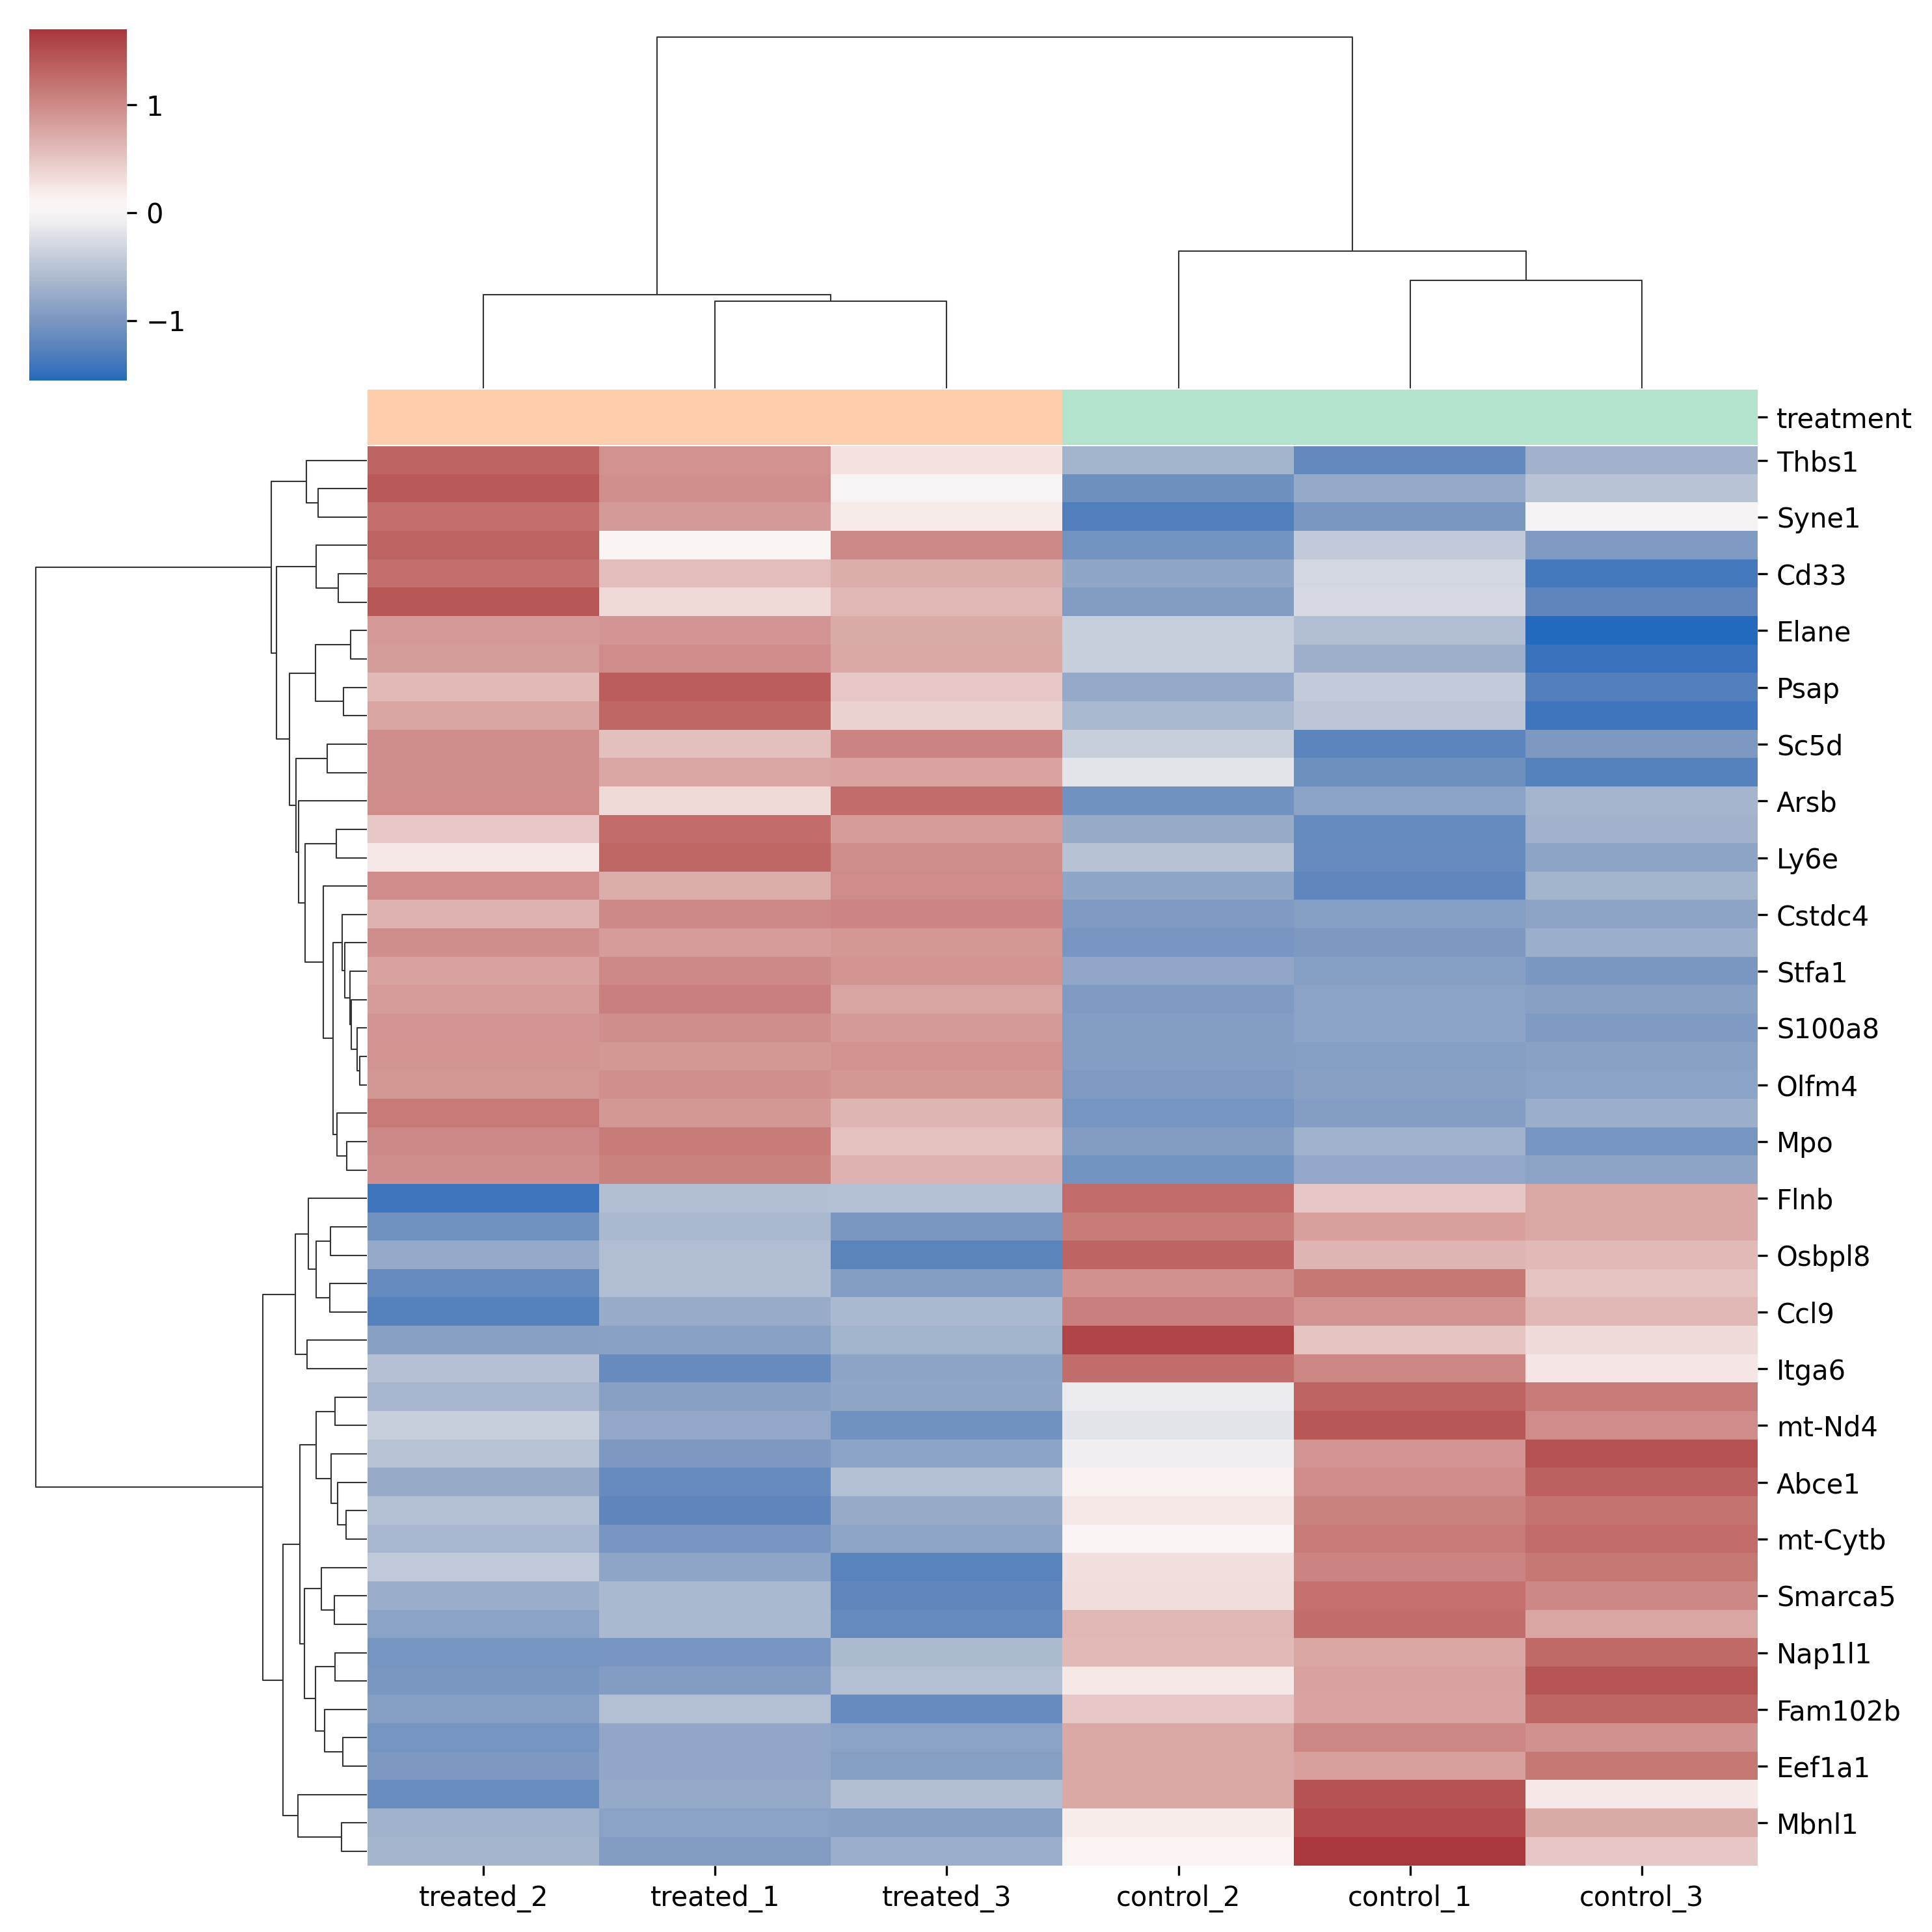

In [12]:

if ('inpath_design' in globals()) & ('outpath' in globals()) & ('refcond' in globals()) & ('compared' in globals()): heat = csl.visualization_heatmap(inpath_design,outpath,refcond,compared); heat
else: 
    inpath_design,outpath,refcond,compared=csl.visualization_PrepDirect(); heat = csl.visualization_heatmap(inpath_design,outpath,refcond,compared); heat


### Visualization step: Visualize the PC plot below
<a id='visualization_point'></a>

Here's the list of phenotype/condition/replicate/batch:
Index
           0
0  treatment
Which index of phenotype/condition/replicate/batch to view PC plot?
0


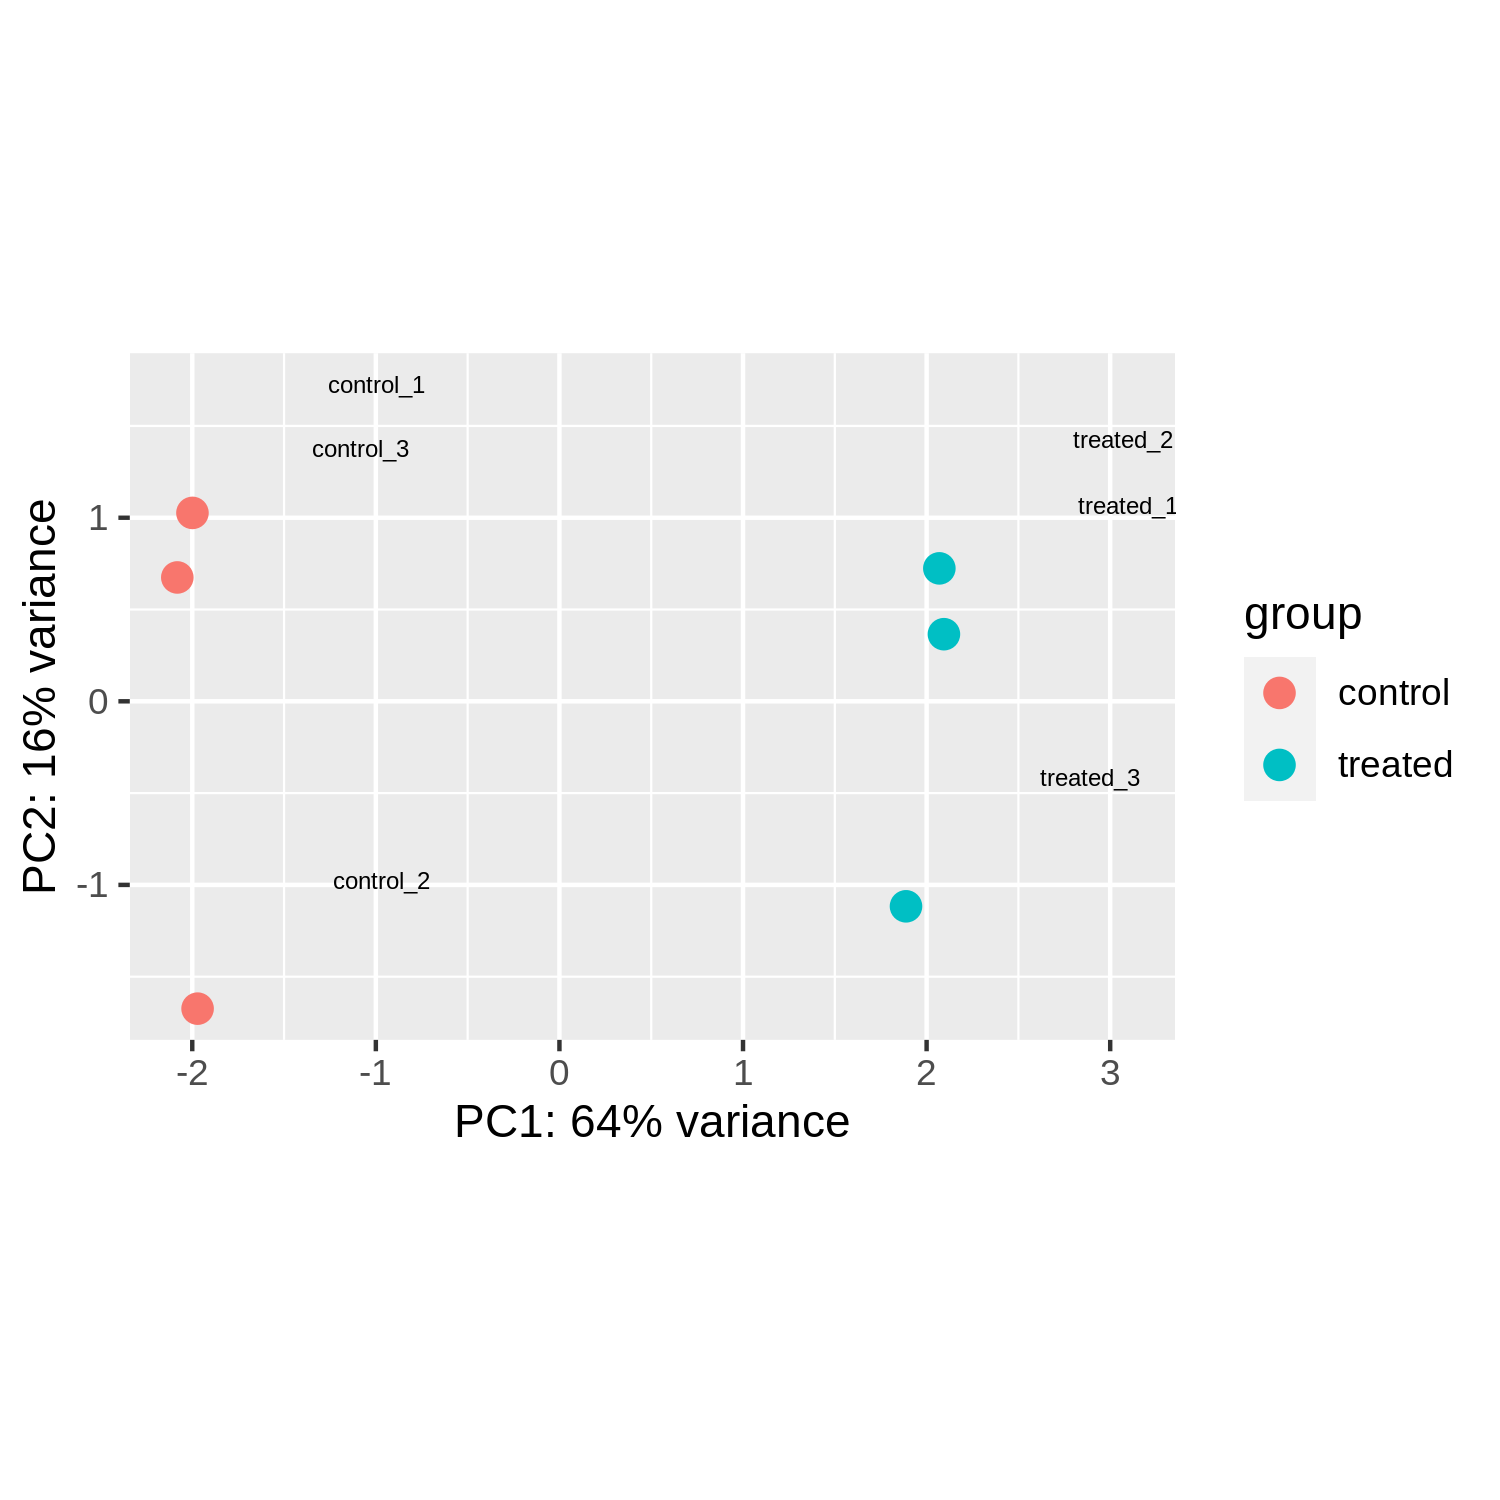

In [13]:

from IPython.display import Image; outpath,inpca,design_var = csl.visualization_pca(design_var); Image(outpath+"/pca_"+design_var.iloc[inpca,0]+"_"+compared+"_vs_"+refcond+"(ref).png")


### Visualization step: Visualize the MA plot below
<a id='visualization_point'></a>

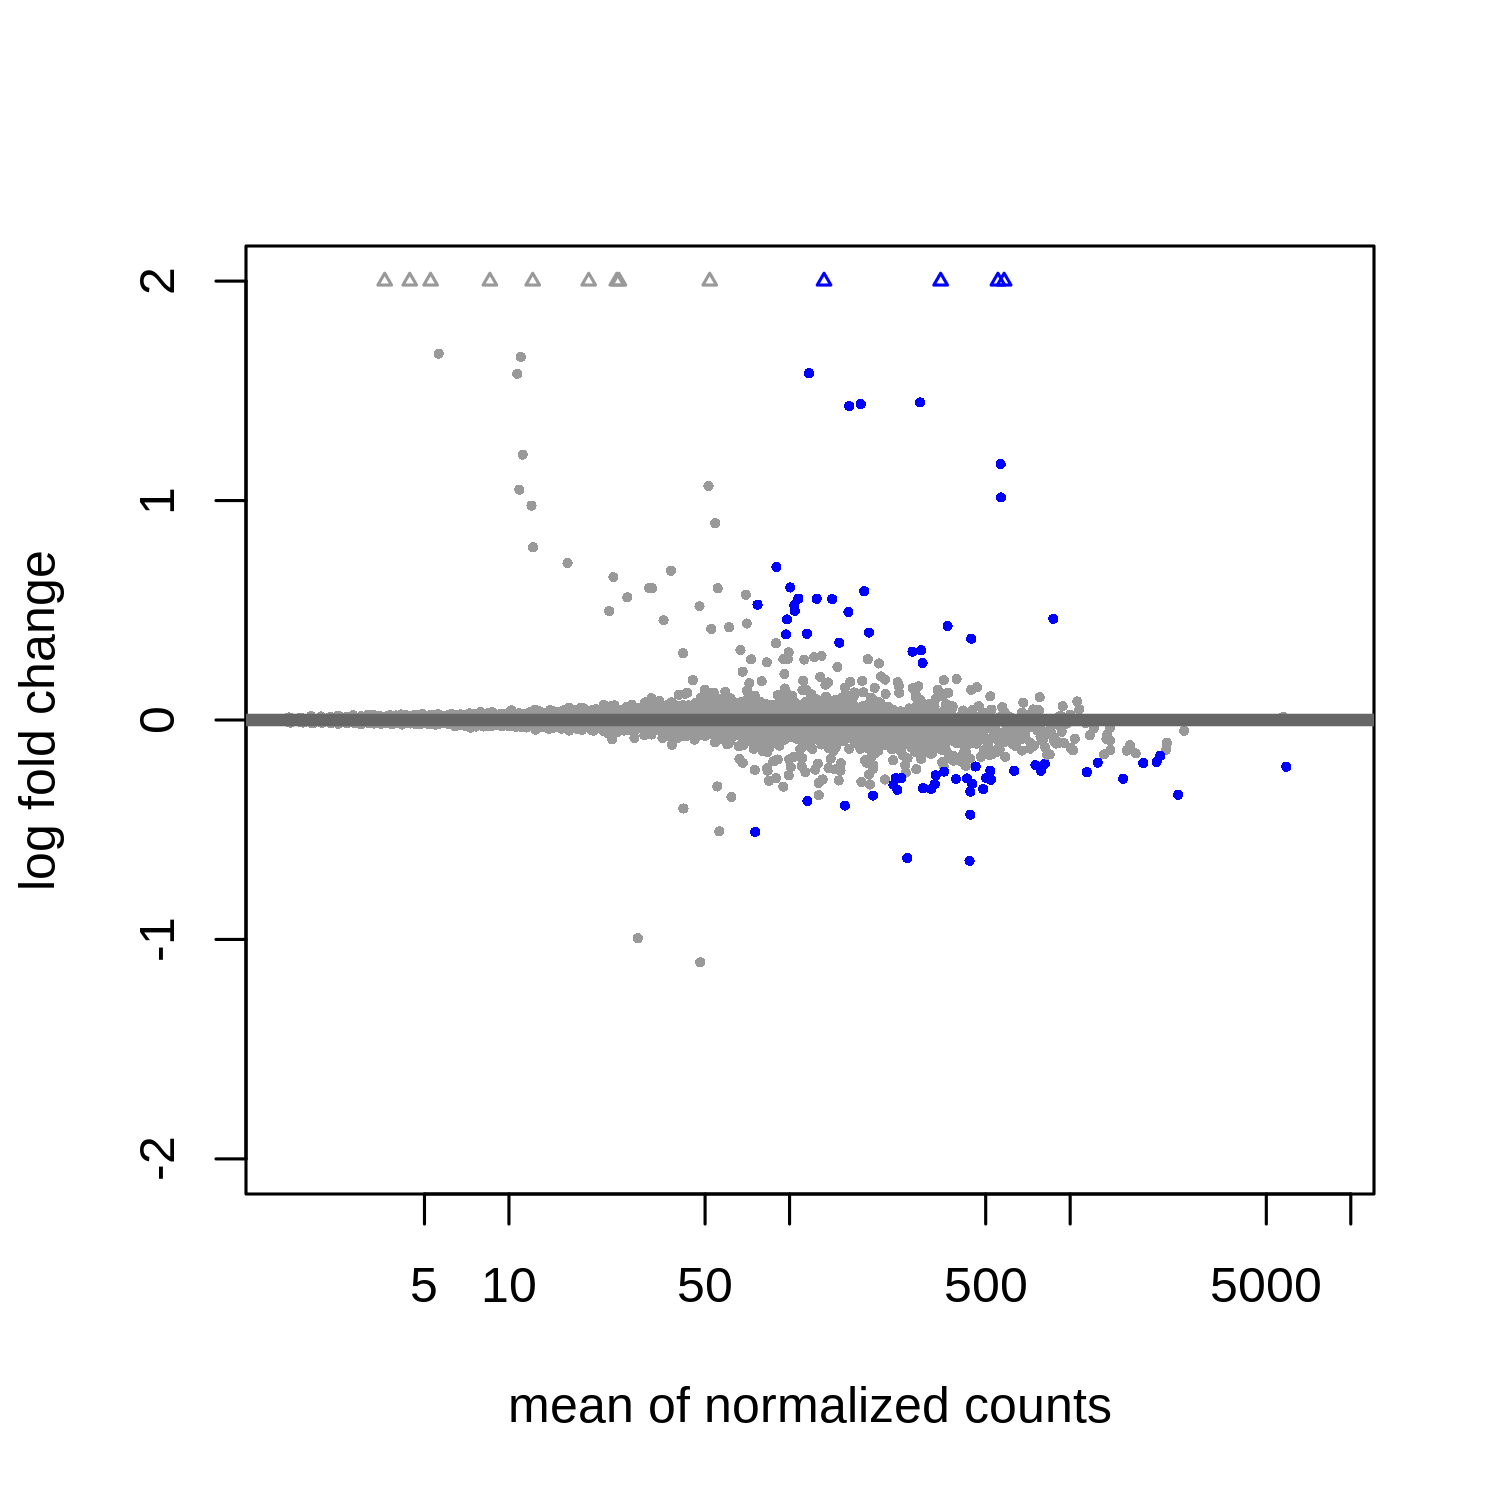

In [14]:

from IPython.display import Image; Image(outpath+"/MAplot_"+compared+'_vs_'+refcond+"(ref).png")


### Visualization step: Visualize the volcano plot below 
<a id='visualization_point'></a>

In [ ]:

from IPython.display import Image; Image(outpath+"/volcano_"+compared+'_vs_'+refcond+"(ref).png")


### [Click here if you want to return to very beginning](#starting_point)
<a id='FindCopyResults_point'></a>

### ======================================================================================

# <font color='darkblue'> Find the result contents and locations

In [15]:

csl.Tree()


../../csl_results/
└── example_dataset
    ├── data
    │   ├── counts
    │   │   ├── count_matrix.txt
    │   │   └── featurecounts_summary.txt
    │   ├── deseq2
    │   │   ├── DEG_fdr0.05_treated_vs_control(ref).txt
    │   │   ├── DEG_treated_vs_control(ref).txt
    │   │   ├── heatmap_treatment.png
    │   │   ├── MAplot_treated_vs_control(ref).png
    │   │   ├── normalized_counts.txt
    │   │   └── pca_treatment.png
    │   ├── fastq
    │   │   ├── control_1_R1_001.fastq.gz
    │   │   ├── control_1_R2_001.fastq.gz
    │   │   ├── control_2_R1_001.fastq.gz
    │   │   ├── control_2_R2_001.fastq.gz
    │   │   ├── control_3_R1_001.fastq.gz
    │   │   ├── control_3_R2_001.fastq.gz
    │   │   ├── treated_1_R1_001.fastq.gz
    │   │   ├── treated_1_R2_001.fastq.gz
    │   │   ├── treated_2_R1_001.fastq.gz
    │   │   ├── treated_2_R2_001.fastq.gz
    │   │   ├── treated_3_R1_001.fastq.gz
    │   │   └── treated_3_R2_001.fastq.gz
    │   ├── fastqc
    │   │   ├── control_1_R1_

### ======================================================================================

# <font color='darkblue'> Copy specific results to your local computer (e.g copy all differential analysis results)
### Open <font color='darkred'> terminal/bash <font color='black'> on your local computer then <font color='darkred'> copy+paste <font color='black'> the following:
scp -r TypeYourCshlUsername@bamdev1:~/csl_results/data/deseq2/ . 
### Change <font color='darkred'> TypeYourCshlUsername <font color='black'> into you actual <font color='darkred'> CSHL username <font color='black'>
### Press <font color='darkred'> enter/return <font color='black'>
### It will ask to type your <font color='darkred'> CSHL password <font color='black'>
### The files will be downloaded to your home folder on your local computer 
